# Lab 1 - Dimensionality Reduction
## Machine Learning II

Moisés Alfonso Guerrero Jiménez

In [1]:
# Modules
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

from PIL import Image

### Workshop I
1. Simulate a random rectangular matrix A
    - What is the rank and trace of A?
    - What is the determinant of A?
    - Can you invert A? How?
    - How are eigenvalues and eigenvectors of A'A and AA' related? What interesting differences can you notice between both?
    - See [https://sites.cs.ucsb.edu/~mturk/Papers/jcn.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/jcn.pdf)

**R/** For simulating a rectangular matrix $A$ with dimensions $m\times n$ we could specify inputs for dimensions $m$ and $n$. For this exercise, I will simulate matrix $A$ only with integer values by using `numpy.random.randint()`, that lets us to set lower and higher integers to include in the matrix and its dimensions $m\times n$.

In this case I will generate a square matrix with integer values between -20 and 20

In [2]:
# 1. Random matrix simulation
low = int(input("Lowest integer of the matrix: "))
high = int(input("Highest integer of the matrix: "))
m = int(input("Number of rows: "))
n = int(input("Number of columns: "))
np.random.seed(seed=1234) # Optional: Configuring seed for pseudo-random generation
A = np.random.randint(low=low, high=high, size=(m, n))
print(f"Generating matrix A_{m}x{n} with integer values between {low} and {high}...")
print(f"A = \n{A}")

Generating matrix A_6x6 with integer values between -20 and 20...
A = 
[[ -1  18  -8   4  -5   3]
 [  6  10  10   6   8 -15]
 [ -4 -11  -8  17  14  18]
 [-17  19  -9 -20  -9  -4]
 [-17 -18  -1  -8 -19  -9]
 [ -3  -6 -13   8  -3   3]]


**Rank**

Rank is defined as the number of linearly independent columns of a matrix $A \in \mathbb{R}^{m\times n}$ equals the number of linearly independent rows of the matrix.

In the case of Python it is possible to obtain the matrix rank by using `numpy.linalg.matrix_rank()`.

In [3]:
# Rank of matrix A
print(f"rank(A) = {np.linalg.matrix_rank(A)}")

rank(A) = 6


**Trace**

In the case of the trace of a square matrix $A \in \mathbb{R}^{n\times n}$ it is defined as the sum of the elements on the main diagonal. 

$$trace(A)=\sum_{i=1}^{n}{a_{ii}}$$

In python it is possible to obtain it by using `numpy.trace()`, but it is important to verify that the matrix is a square matrix to satisfy the properties:

1. $trace(A+B)=trace(A)+trace(B)\ for\ A,B \in \mathbb{R}^{n\times n}$
2. $trace(\alpha A)=\alpha trace(A),\alpha \in \mathbb{R}\ for\ A \in \mathbb{R}^{n\times n}$
3. $trace(I_{n})=n$
4. $trace(AB)=trace(BA)\ for\ A\in \mathbb{R}^{n\times k}, B\in \mathbb{R}^{k\times n}$
5. $trace(A)=trace(A^{T})$

I this case we have a square matrix so it is possible to obtain the trace by using this function.

In [4]:
print(f"A = \n{A}")
print(f"trace(A) = {np.trace(A)}")

A = 
[[ -1  18  -8   4  -5   3]
 [  6  10  10   6   8 -15]
 [ -4 -11  -8  17  14  18]
 [-17  19  -9 -20  -9  -4]
 [-17 -18  -1  -8 -19  -9]
 [ -3  -6 -13   8  -3   3]]
trace(A) = -35


**Determinant**

Determinants are only defined for square matrices $A \in \mathbb{R}^{n\times n}$ we can obtain it with python by using `numpy.linalg.det()`

In [5]:
print(f"det(A) = {np.linalg.det(A)}")

det(A) = 48743889.99999994


**Invertibility of A**

The matrix $A \in \mathbb{R}^{n\times n}$ is invertible if its determinant is different from zero.

In this case we can see that it is invertible so I will obtain it with python by using `numpy.linalg.inv()`.

In [6]:
# Inverse of the matrix A
print(f"A = \n{A}")
print(f"A^-1 = \n{np.round(np.linalg.inv(A), 3)}")

A = 
[[ -1  18  -8   4  -5   3]
 [  6  10  10   6   8 -15]
 [ -4 -11  -8  17  14  18]
 [-17  19  -9 -20  -9  -4]
 [-17 -18  -1  -8 -19  -9]
 [ -3  -6 -13   8  -3   3]]
A^-1 = 
[[-0.018 -0.027 -0.051 -0.023 -0.04   0.041]
 [ 0.038  0.008  0.005  0.006 -0.002 -0.024]
 [ 0.042  0.002  0.024 -0.025  0.036 -0.101]
 [ 0.054  0.027  0.024 -0.027  0.029 -0.011]
 [-0.061  0.026  0.02   0.035 -0.031  0.024]
 [ 0.035 -0.045  0.019 -0.014  0.002 -0.059]]


We can check it by using the property $AA^{-1} = I_{n}$

In [7]:
# Matrix multiplication of A and A^-1
print(f"A*A^-1 = \n{np.round(np.matmul(A, np.linalg.inv(A)), decimals=0).astype(int)}")

A*A^-1 = 
[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


**Eigenvalues and eigenvectors of $AA^{T}$ and $A^{T}A$**

In [8]:
# TODO: finish this exercise

2. Add a steady, well-centered picture of your face to a shared folder alongside your classmates.
    - Edit your picture to be 256x256 pixels, grayscale (single channel).
    - Plot your edited face
    - Calculate and plot the average face of the cohort
    - How distant is your face from the average? How would you measure it?

**R/** It is necessary to specify input and output directories where images will be located, for that I will include a config file with name `lab1_config.json` in local directory with parameters specified.

**Note\*:** By default configured directories are also included in `.gitignore` file to avoid them to be included on the main repo.

In [9]:
# Reading configuration file
file = "lab1_config.json"
config_file = open(file)
config = json.load(config_file)
print(f"config file = \n{json.dumps(config, indent=2)}")

config file = 
{
  "personal_photo_input_path": "imgs/personal/Moises_Guerrero.jpeg",
  "personal_photo_output_path": "imgs/cohort/Moises_Guerrero.jpg",
  "cohort_photos_dir": "imgs/cohort/"
}


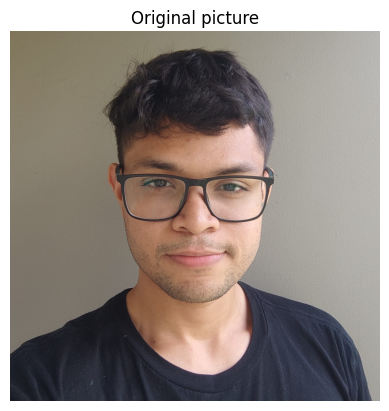

In [10]:
face_img = imread(config['personal_photo_input_path'])
# Original picture
plt.imshow(face_img)
plt.title("Original picture")
plt.axis('off')
plt.show()

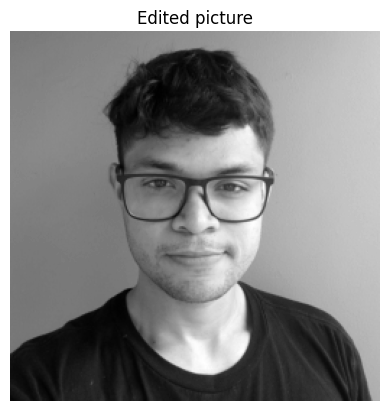

Saving edited photo in output path: 'imgs/cohort/Moises_Guerrero.jpg'...


In [11]:
# Grayscale image with 256x256 pixels
resized_img = resize(face_img, (256,256,3))
# rgb2gray function changes color scale to a float number between 0 and 1
# So I will multiplicate it by 255 and round.
grayscale_img = np.round(255*rgb2gray(resized_img)).astype(np.uint8)
# Edited picture
plt.imshow(grayscale_img, cmap="gray")
plt.title("Edited picture")
plt.axis('off')
plt.show()
print(f"Saving edited photo in output path: '{config['personal_photo_output_path']}'...")
Image.fromarray(grayscale_img).save(config['personal_photo_output_path'])

**Average face of the cohort**

For that it is necessary to read all available photos in local directory, add all of them and then divide by the number of available photos. In python it is possible to list all available photos in local directory by using `os.listdir()`.

In [16]:
faces_file_list = os.listdir(config['cohort_photos_dir'])
faces_file_list

['Andres_Licona.jpg',
 'Cristian_Caballero.jpg',
 'Jacobo ML (1).jpg',
 'jeison_arias.jpg',
 'john_alzate.jpg',
 'Juan_Rojas.jpg',
 'Luis_Román.jpg',
 'Moises_Guerrero.jpg',
 'sara_durango.jpg',
 'tatiana_garcia.jpg']

Adding photo Andres_Licona.jpg with shape (256, 256)...
Adding photo Cristian_Caballero.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo Jacobo ML (1).jpg with shape (256, 256)...
Adding photo jeison_arias.jpg with shape (256, 256)...
Adding photo john_alzate.jpg with shape (256, 256)...
Adding photo Juan_Rojas.jpg with shape (256, 256)...
Adding photo Luis_Román.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo Moises_Guerrero.jpg with shape (256, 256)...
Adding photo sara_durango.jpg with shape (256, 256, 3)...
  Converting to a single channel image...
Adding photo tatiana_garcia.jpg with shape (256, 256)...
Calculating average face...
[[137 136 144 ... 146 146 146]
 [137 136 145 ... 146 146 146]
 [137 137 145 ... 146 146 146]
 ...
 [ 59  58  58 ...  67  68  65]
 [ 57  57  58 ...  67  68  65]
 [ 55  56  57 ...  66  66  65]]


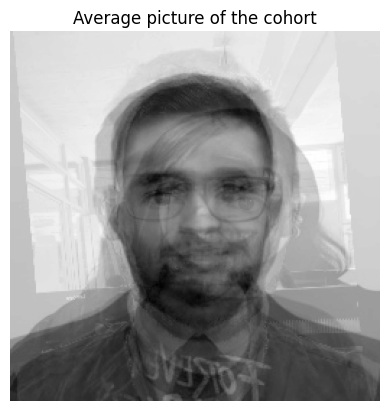

In [17]:
avg_face = np.zeros((256,256))
for face in faces_file_list:
    img = imread(os.path.join(config['cohort_photos_dir'], face))
    print(f"Adding photo {face} with shape {img.shape}...")
    if len(img.shape) > 2:
        print("  Converting to a single channel image...")
        img = rgb2gray(img)
    avg_face += img
print("Calculating average face...")
avg_face = avg_face/len(faces_file_list)
avg_face_uit8 = np.round(avg_face, decimals=0).astype(np.uint8)
print(avg_face_uit8)
plt.imshow(avg_face_uit8, cmap="gray")
plt.title("Average picture of the cohort")
plt.axis('off')
plt.show()

In [14]:
# TODO: Finish the exercise

3. Let's create the unsupervised Python package
    - Same API as scikit-learn: fit(), fit_transform(), transform(), hyperparams at init.
    - Manage dependencies with Pipenv and Numpy
    - Implement SVD from scratch using Python and Numpy
    - Implement PCA from scratch using Python and Numpy [https://github.com/rushter/MLAlgorithms/blob/master/mla/pca.py, https://github.com/patchy631/machine-learning/blob/main/ml_from_scratch/PCA_from_scratch.ipynb]
    - Implement t-SNE from scratch using Python and Numpy [https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/]